In [1]:
import numpy as np
import pickle
import os
import pandas as pds
from names_dataset import NameDataset
from tqdm import tqdm
import datetime
import squarify
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

Sources:

- Countries 2 letters code from: https://gist.github.com/mlisovyi/e8df5c907a8250e14cc1e5933ed53ffd

- Age distributions from: the World Bank (helped with Chatgpt), the World Health Organization (helped with Chatgpt), the World Factbook (cia.gov)

- Population sizes from: United Nations Department of Economic and Social Affairs, Eurostat and the World Bank (helped with Chatgpt)

- names and last names from: https://github.com/philipperemy/name-dataset (Facebook Data Leak 2019)

In [2]:
with open(os.path.join('..', 'european countries data', 'european_countries_code.pkl'), 'rb') as f:
    european_countries_code = pickle.load(f)

with open(os.path.join('..', 'european countries data', 'european_countries_pop.pkl'), 'rb') as f:
    european_countries_pop = pickle.load(f)

with open(os.path.join('..', 'european countries data', 'european_countries_age.pkl'), 'rb') as f:
    european_countries_age = pickle.load(f)

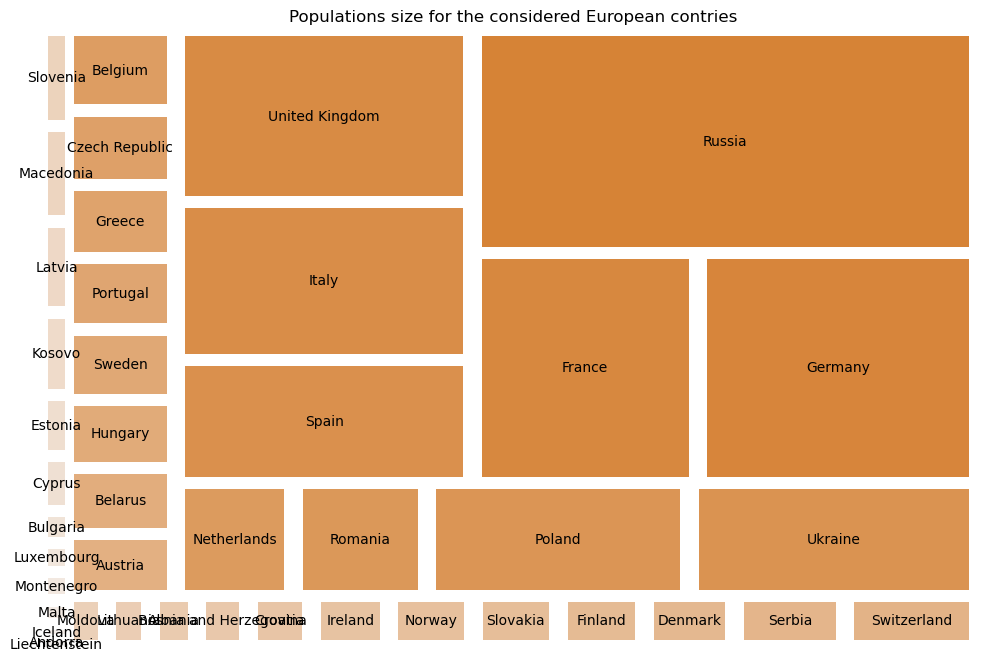

In [3]:
plt.figure(figsize=(12,8))
plt.title(f"Populations size for the considered European contries")
squarify.plot(sorted(european_countries_pop.values()), label=sorted(european_countries_pop, key=european_countries_pop.get), alpha=0.8, color=sns.light_palette('#cc6404', len(european_countries_pop)), pad=True)
plt.axis('off')
plt.show()

In [5]:
# generate dataset with identifiers (names, birth year, nationality, gender)

# expected size of the final dataframe:
N = 100

country = list(european_countries_code.keys())[0]

country_code = european_countries_code[country]
pop_proportion = european_countries_pop[country]
age_distr = european_countries_age[country]

path_country_data = os.path.join('..','..','..','data names',country_code+'.csv')

big_df = pds.read_csv(path_country_data, delimiter = ',', names = ['name', 'family name', 'gender', 'country'])
sample_df = big_df.sample(n = int(N*pop_proportion))
sample_df['birth year'] = 2020 - np.random.choice(a = [np.random.randint(int(interval[:2]), int(interval[3:])) for interval in age_distr.keys()], size = sample_df.shape[0], p = list(age_distr.values()))

# dict of the probability (for each country) of each name:
country_proba_names = {}
country_proba_names[country] = { k:big_df[big_df.name == k].shape[0]/big_df.shape[0] for k in sample_df.name.unique() }

for country in tqdm(list(european_countries_code.keys())[1:]):
    try:
        country_code = european_countries_code[country]
        pop_proportion = european_countries_pop[country]
        age_distr = european_countries_age[country]

        path_country_data = os.path.join('..','..','..','data names',country_code+'.csv')

        tmp_big_df = pds.read_csv(path_country_data, delimiter = ',', names = ['name', 'family name', 'gender', 'country'])
        tmp_sample_df = tmp_big_df.sample(n = int(N*pop_proportion))
        tmp_sample_df['birth year'] = 2020 - np.random.choice(a = [np.random.randint(int(interval[:2]), int(interval[3:])) for interval in age_distr.keys()], size = tmp_sample_df.shape[0], p = list(age_distr.values()))
        
        sample_df = pds.concat([sample_df, tmp_sample_df])

        country_proba_names[country] = { k:tmp_big_df[tmp_big_df.name == k].shape[0]/tmp_big_df.shape[0] for k in tmp_sample_df.name.unique() }

    except FileNotFoundError:
        pass

sample_df

100%|██████████| 42/42 [01:04<00:00,  1.53s/it]


,name,family name,gender,country,birth year
856090,Natascha,Blvck,F,AT,2004
2932345,Wilfried,Giebens,M,BE,2019
346292,Romice,Omice,NaN,CZ,2000
16230285,Caroline,Mendez,F,FR,1964
15119288,Maithe,Chapuis,F,FR,1979
...,...,...,...,...,...
10383814,Claudette,Hendricks,F,GB,1989
6130530,Melanie,Sinclair,F,GB,1989
6120641,David,Le Guern,M,GB,2000
2585384,Edgar,Edgar,M,GB,2016


In [6]:
s = 0
for key in country_proba_names:
    s += len(country_proba_names[key])
with open(os.path.join('..', 'dictionaries', f'country_proba_names_{s}names.pkl'), 'wb') as f:
    pickle.dump(country_proba_names, f)

sample_df.to_csv(os.path.join('..', 'datasets', f'DF_N={sample_df.shape[0]}_{datetime.date.today()}.csv'), index = False)